<a href="https://colab.research.google.com/github/AdhamelGazar/Traffic-Sign-detection/blob/main/Traffic_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Download and unzipping the data*

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adhamamr3","key":"91434b874e7a8d322e9d455b5478db03"}'}

In [4]:
 !mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!pwd

/content


In [8]:
!mkdir dataset

In [9]:
%cd /content/dataset

/content/dataset


In [10]:
!pwd

/content/dataset


In [11]:
!kaggle datasets download -d wjybuqi/traffic-sign-classification-and-recognition

 87% 22.0M/25.3M [00:00<00:00, 73.4MB/s]
100% 25.3M/25.3M [00:00<00:00, 100MB/s] 


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!unzip /content/dataset/traffic-sign-classification-and-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_dataset/train/GuideSign/01075.jpg  
  inflating: train_dataset/train/GuideSign/01076.jpg  
  inflating: train_dataset/train/GuideSign/01077.jpg  
  inflating: train_dataset/train/GuideSign/01078.jpg  
  inflating: train_dataset/train/GuideSign/01080.jpg  
  inflating: train_dataset/train/GuideSign/01081.jpg  
  inflating: train_dataset/train/GuideSign/01082.jpg  
  inflating: train_dataset/train/GuideSign/01083.jpg  
  inflating: train_dataset/train/GuideSign/01084.jpg  
  inflating: train_dataset/train/GuideSign/01085.jpg  
  inflating: train_dataset/train/GuideSign/01086.jpg  
  inflating: train_dataset/train/GuideSign/01087.jpg  
  inflating: train_dataset/train/GuideSign/01088.jpg  
  inflating: train_dataset/train/GuideSign/01089.jpg  
  inflating: train_dataset/train/GuideSign/01090.jpg  
  inflating: train_dataset/train/GuideSign/01091.jpg  
  inflating: train_dataset/train/GuideSign/01092.jpg  
  inflating: t

# Exploring the dataset

In [19]:
%cd /content/dataset/train_dataset/train

/content/dataset/train_dataset/train


In [20]:
!pwd

/content/dataset/train_dataset/train


In [21]:
import os

In [22]:
print(f"We have a total number of {len(os.listdir('./'))} classes")

We have a total number of 10 classes


In [23]:
for folder in os.listdir('./'):
  images = [x for x in os.listdir(f'./{folder}') if (x.endswith('.jpg') or x.endswith('.jpeg'))]
  print(f'{folder} : {len(images)} images')

M5 : 213 images
M6 : 134 images
P12 : 95 images
P1 : 249 images
W1 : 145 images
M4 : 3206 images
P10_50 : 95 images
GuideSign : 1171 images
M1 : 247 images
M7 : 469 images


# Reading and Showing Data

In [24]:
import cv2 as cv
from google.colab.patches import cv2_imshow

In [25]:
img = cv.imread('/content/dataset/train_dataset/train/GuideSign/00001.jpg')

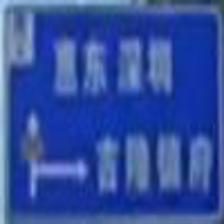

In [26]:
cv2_imshow(img)

In [27]:
img.shape

(224, 224, 3)

# Data Generator

In [28]:
import tensorflow.keras as keras
import numpy as np
from sklearn.model_selection import train_test_split

In [29]:
CLASSES_labels = {}
for index, folder in enumerate(os.listdir('./')):
  if folder.startswith('.'):
    continue
  CLASSES_labels[folder] = index

In [30]:
CLASSES_labels

{'GuideSign': 7,
 'M1': 8,
 'M4': 5,
 'M5': 0,
 'M6': 1,
 'M7': 9,
 'P1': 3,
 'P10_50': 6,
 'P12': 2,
 'W1': 4}

In [31]:
images_paths = []
images_labels = []
for folder in os.listdir('./'):
  images = [folder + '/' + x for x in os.listdir(f'./{folder}') if (x.endswith('.jpg') or x.endswith('.jpeg') or x.endswith('.png'))]
  images_paths = images_paths + images
  label = CLASSES_labels[folder]
  images_labels = images_labels + [label] * len(images)

In [32]:
len(images_paths), len(images_labels)

(6024, 6024)

In [33]:
print(list(zip(images_paths[::1000], images_labels[::1000])))

[('M5/00175.jpg', 0), ('M4/00772.jpg', 5), ('M4/01919.jpg', 5), ('M4/01493.jpg', 5), ('M4/02388.jpg', 5), ('GuideSign/01158.jpg', 7), ('M7/00082.jpg', 9)]


In [34]:
images_paths_train, images_paths_test, images_labels_train, images_labels_test = train_test_split(images_paths, images_labels, test_size=0.1, stratify=images_labels, random_state=42)
images_paths_train, images_paths_validation, images_labels_train, images_labels_validation = train_test_split(images_paths_train, images_labels_train, test_size=0.1, stratify=images_labels_train, random_state=42)

In [35]:
len(images_paths_train), len(images_paths_validation), len(images_paths_test)

(4878, 543, 603)

In [36]:
import numpy as np


In [37]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=16, dim=(64,128), n_channels=1,
              n_classes=10, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of steps per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    list_labels_temp = [self.labels[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp, list_labels_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp, list_labels_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img = cv.imread(ID,cv.IMREAD_GRAYSCALE)
        img_resized = cv.resize(img, self.dim[::-1])          
        X[i,] =  np.expand_dims(img_resized, axis=2)

        # Store class
        y[i] = list_labels_temp[i]

    return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [38]:
train_generator = DataGenerator(list_IDs= images_paths_train, labels= images_labels_train)
validation_generator = DataGenerator(list_IDs= images_paths_validation, labels= images_labels_validation)
test_generator = DataGenerator(list_IDs= images_paths_test, labels= images_labels_test)

(16, 64, 128, 1)
(16, 10)


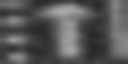

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


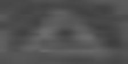

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


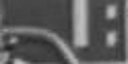

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


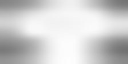

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


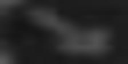

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


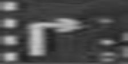

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


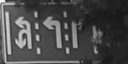

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


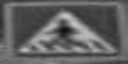

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


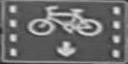

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


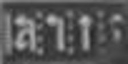

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


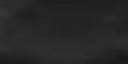

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


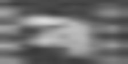

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


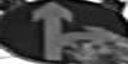

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


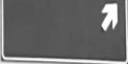

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


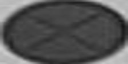

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


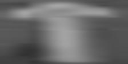

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [39]:
for images, labels in train_generator:
  print(images.shape)
  print(labels.shape)
  for index in range(len(labels)):
    cv2_imshow(images[index])
    print(labels[index])
  break

# Model Dev

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
model = tf.keras.Sequential()
model.add(Input(shape=(64,128, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 128)      1280      
                                                                 
 dropout (Dropout)           (None, 62, 126, 128)      0         
                                                                 
 batch_normalization (BatchN  (None, 62, 126, 128)     512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 124, 128)      147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 62, 128)      0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 30, 62, 128)       0

In [42]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
acc_checkpoint= tf.keras.callbacks.ModelCheckpoint(
    ('/content/drive/MyDrive/Best /bestacc_traffic_signs.h5'),
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None
)


In [44]:
model.fit(x = train_generator,
          validation_data = validation_generator,
          epochs=80,
          callbacks=[acc_checkpoint])

Epoch 1/80
304/304 [==============================] - 49s 122ms/step - loss: 0.7823 - accuracy: 0.7989 - val_loss: 0.3296 - val_accuracy: 0.9072
Epoch 2/80
304/304 [==============================] - 36s 120ms/step - loss: 0.3492 - accuracy: 0.9056 - val_loss: 0.3774 - val_accuracy: 0.8826
Epoch 3/80
304/304 [==============================] - 37s 120ms/step - loss: 0.2459 - accuracy: 0.9305 - val_loss: 0.1888 - val_accuracy: 0.9470
Epoch 4/80
304/304 [==============================] - 36s 119ms/step - loss: 0.1957 - accuracy: 0.9449 - val_loss: 0.1898 - val_accuracy: 0.9413
Epoch 5/80
304/304 [==============================] - 36s 119ms/step - loss: 0.1602 - accuracy: 0.9523 - val_loss: 0.1924 - val_accuracy: 0.9470
Epoch 6/80
304/304 [==============================] - 37s 120ms/step - loss: 0.1854 - accuracy: 0.9447 - val_loss: 0.5583 - val_accuracy: 0.8239
Epoch 7/80
304/304 [==============================] - 36s 119ms/step - loss: 0.1299 - accuracy: 0.9595 - val_loss: 0.2480 - val_ac

# **Evaluating model**

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model = load_model('/content/drive/MyDrive/Best /bestacc_traffic_signs.h5')

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 128)      1280      
                                                                 
 dropout (Dropout)           (None, 62, 126, 128)      0         
                                                                 
 batch_normalization (BatchN  (None, 62, 126, 128)     512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 124, 128)      147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 62, 128)      0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 30, 62, 128)       0

In [48]:
test_generator = DataGenerator(list_IDs= images_paths_test, labels= images_labels_test, batch_size=120, shuffle=False)

In [49]:
y_pred = []
y_true = []
for images, labels in test_generator:
  labels_pred = model.predict(images)
  labels_pred = np.argmax(labels_pred, axis=1)
  labels = np.argmax(labels, axis=1)
  y_pred += list(labels_pred)
  y_true += list(labels)

  


  

In [50]:
len(y_pred), len(y_true)

(600, 600)

In [51]:
from sklearn.metrics import classification_report

In [52]:
target_names = list(CLASSES_labels.keys())

In [53]:
CLASSES_labels.keys()

dict_keys(['M5', 'M6', 'P12', 'P1', 'W1', 'M4', 'P10_50', 'GuideSign', 'M1', 'M7'])

In [54]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          M5       0.87      0.95      0.91        21
          M6       0.92      0.92      0.92        13
         P12       1.00      0.90      0.95        10
          P1       0.92      0.96      0.94        25
          W1       1.00      0.93      0.97        15
          M4       0.98      0.98      0.98       319
      P10_50       1.00      1.00      1.00         9
   GuideSign       0.97      0.97      0.97       116
          M1       0.96      0.96      0.96        25
          M7       1.00      0.96      0.98        47

    accuracy                           0.97       600
   macro avg       0.96      0.95      0.96       600
weighted avg       0.97      0.97      0.97       600

